In [34]:
import pandas as pd                                                                                               
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from keras.layers import SimpleRNN, Dense, GRU
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [2]:
df = pd.read_csv('yakutsk_weather.csv', 
                 sep=';',
                 parse_dates=['LocalTime'])

In [3]:
df.isna().sum()

LocalTime    0
T            1
P0           2
P            2
U            3
DD           3
dtype: int64

In [4]:
df = df.dropna()
df.isna().sum()

LocalTime    0
T            0
P0           0
P            0
U            0
DD           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116044 entries, 0 to 116050
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   LocalTime  116044 non-null  datetime64[ns]
 1   T          116044 non-null  float64       
 2   P0         116044 non-null  float64       
 3   P          116044 non-null  float64       
 4   U          116044 non-null  float64       
 5   DD         116044 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 6.2+ MB


In [6]:
dds = df['DD'].unique()
dds_dict = dict(zip(dds, range(len(dds))))
print(dds_dict)
df['DD'] = df['DD'].replace(dds_dict)

{'Ветер': 0, 'Штиль': 1, 'Переменное направление': 2}


In [7]:
df = df.loc[(df['LocalTime'].dt.year == 2018) | (df['LocalTime'].dt.year == 2019)]
df = df.sort_values('LocalTime')
df.head()

,LocalTime,T,P0,P,U,DD
48384,2018-01-01 00:00:00,-34.0,761.6,775.5,67.0,1
48383,2018-01-01 00:30:00,-34.0,761.6,775.5,67.0,1
48382,2018-01-01 01:00:00,-33.0,761.6,775.5,67.0,1
48381,2018-01-01 01:30:00,-33.0,761.6,775.5,67.0,1
48380,2018-01-01 02:00:00,-33.0,761.6,775.5,67.0,1


In [24]:
dfd = df.groupby(df['LocalTime'].dt.date).mean()
dfd = dfd.reset_index()
dfd['LocalTime'] = pd.to_datetime(dfd['LocalTime'])
dfd.head()

,LocalTime,T,P0,P,U,DD
0,2018-01-01,-30.854167,761.966667,775.733333,71.645833,0.375000
1,2018-01-02,-37.791667,758.914583,773.037500,65.437500,0.604167
2,2018-01-03,-29.979167,746.372917,759.822917,73.104167,0.145833
3,2018-01-04,-11.270833,740.718750,753.102083,59.583333,0.000000
4,2018-01-05,2.630435,750.236957,762.143478,40.630435,0.065217


In [25]:
train_df = dfd.loc[dfd['LocalTime'].dt.year == 2018]
test_df = dfd.loc[dfd['LocalTime'].dt.year == 2019]

In [32]:
features = ['P0', 'P', 'U', 'DD']
target = ['T']
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [33]:
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.fit_transform(y_test)

In [91]:
lookback = 3

generator = TimeseriesGenerator(x_train, y_train, length=lookback)
test_generator = TimeseriesGenerator(x_test, y_test, length=lookback)

In [92]:
X_train = np.empty((len(generator), lookback, len(features)))
Y_train = np.empty((len(generator)))

for i in range(len(generator)):
  x, y = generator[i]
  X_train[i] = x[0]
  Y_train[i] = y[0]

X_test = np.empty((len(generator), lookback, len(features)))
Y_test = np.empty((len(generator)))

for i in range(len(test_generator)):
  x, y = test_generator[i]
  X_test[i] = x[0]
  Y_test[i] = y[0]


In [84]:
model = Sequential()
model.add(SimpleRNN(32))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae', 'mse'],
)

history = model.fit(
    X_train, Y_train,
    epochs=50,
    verbose=0,
    validation_data=(X_test, Y_test),
)

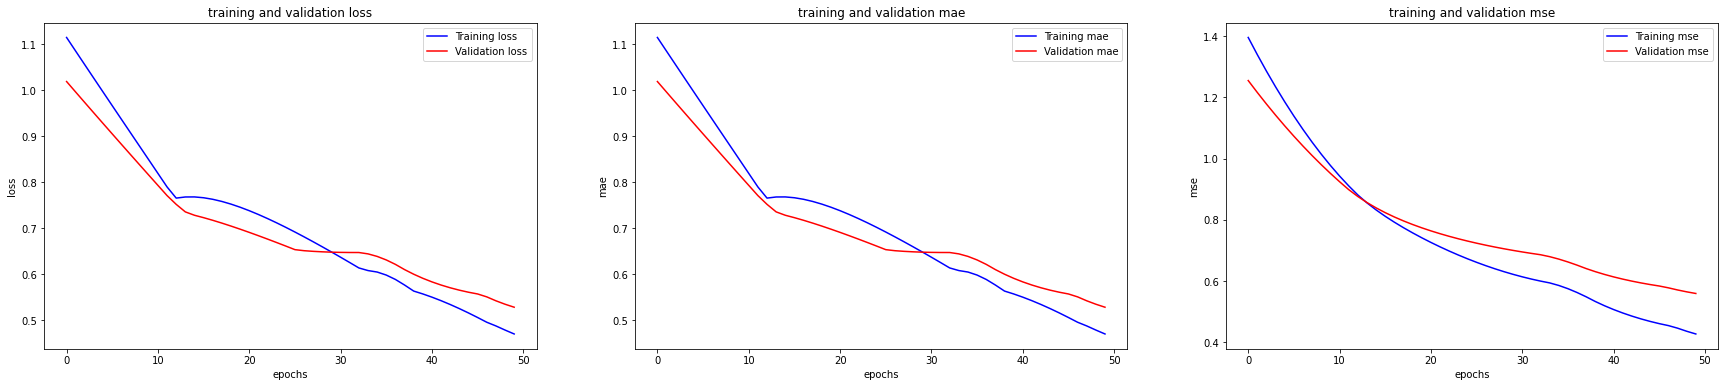

In [79]:
def visualize_metrics(history):
  metrics = ["loss", "mae", "mse"]
  plt.figure(figsize=(30, 6))
  for i, m in enumerate(metrics):
    train = history[m]
    test = history[f"val_{m}"]
    epochs = range(len(train))
    plt.subplot(1, len(metrics), i+1)
    plt.plot(epochs, train, "b", label=f"Training {m}")
    plt.plot(epochs, test, "r", label=f"Validation {m}")
    plt.title(f"training and validation {m}")
    plt.xlabel("epochs")
    plt.ylabel(m)
    plt.legend()
  plt.show()

visualize_metrics(history.history)

In [87]:
def show_metrics(test, pred):
  test = y_scaler.inverse_transform(test)
  pred = y_scaler.inverse_transform(pred)
  print(f'r2 \t{r2_score(test, pred)}')
  print(f'mae \t{mean_absolute_error(test, pred)}')
  print(f'mse \t{mean_squared_error(test, pred)}')

y_pred = model.predict(X_test)
print(f'SimpleRNN(lookback={lookback}) metrics:')
show_metrics(Y_test, y_pred)

SimpleRNN(lookback=3) metrics:
r2 	0.6582440943870362
mae 	10.077407995859783
mse 	172.95700086152877


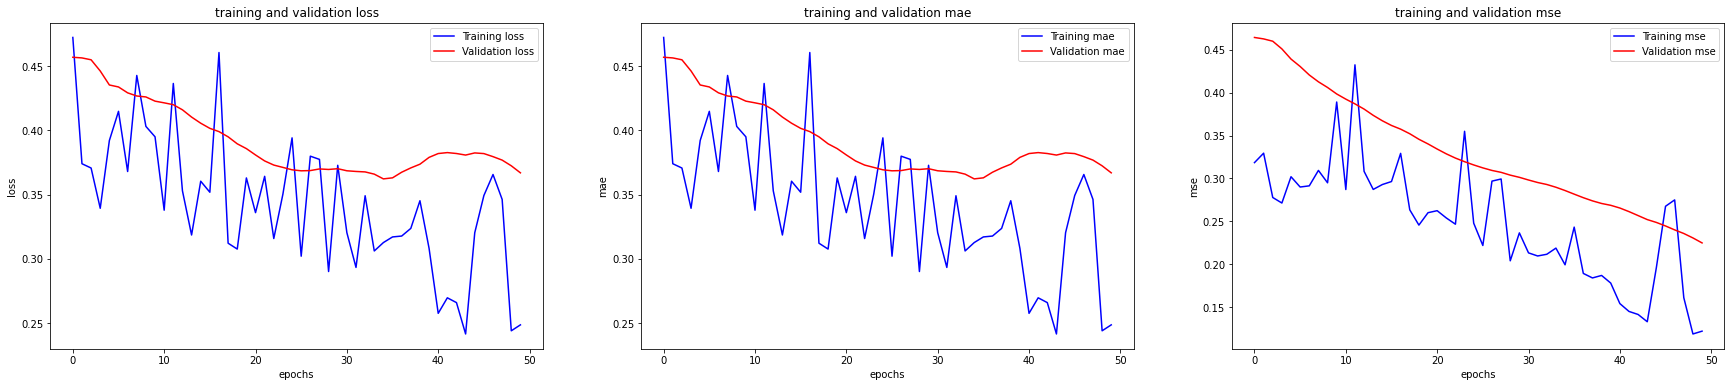

GRU with dropout(lookback=3) metrics:
r2 	0.6675281271193231
mae 	8.014720069037542
mse 	107.18613556409566


In [97]:
model = Sequential()
model.add(GRU(32, dropout=0.1))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae', 'mse'],
)

history = model.fit(
    X_train, Y_train,
    epochs=50,
    verbose=0,
    validation_data=(X_test, Y_test),
)

visualize_metrics(history.history)

y_pred = model.predict(X_test)
print(f'GRU with dropout(lookback={lookback}) metrics:')
show_metrics(Y_test, y_pred)

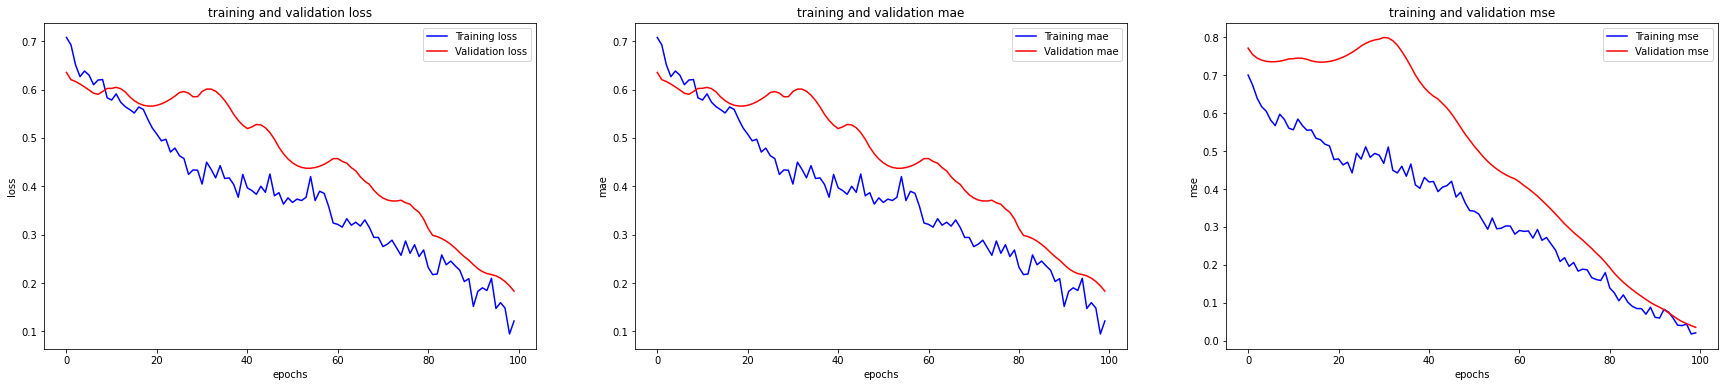

GRU stack(lookback=3) metrics:
r2 	0.9481649065229334
mae 	3.9995960692564636
mse 	16.71119817827257


In [106]:
model = Sequential()
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, dropout=0.1))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae', 'mse'],
)

history = model.fit(
    X_train, Y_train,
    epochs=100,
    verbose=0,
    validation_data=(X_test, Y_test),
)

visualize_metrics(history.history)

y_pred = model.predict(X_test)
print(f'GRU stack(lookback={lookback}) metrics:')
show_metrics(Y_test, y_pred)

In [113]:
lookbacks = [3, 7, 14]
for lookback in lookbacks: 
  generator = TimeseriesGenerator(x_train, y_train, length=lookback)
  test_generator = TimeseriesGenerator(x_test, y_test, length=lookback)

  X_train = np.empty((len(generator), lookback, len(features)))
  Y_train = np.empty((len(generator)))

  for i in range(len(generator)):
    x, y = generator[i]
    X_train[i] = x[0]
    Y_train[i] = y[0]

  X_test = np.empty((len(generator), lookback, len(features)))
  Y_test = np.empty((len(generator)))

  for i in range(len(test_generator)):
    x, y = test_generator[i]
    X_test[i] = x[0]
    Y_test[i] = y[0]

  model = Sequential()
  model.add(GRU(32, return_sequences=True))
  model.add(GRU(32, dropout=0.1))
  model.add(Dense(1))

  model.compile(
      optimizer='adam',
      loss='mae',
      metrics=['mae', 'mse'],
  )

  history = model.fit(
      X_train, Y_train,
      epochs=100,
      verbose=0,
      validation_data=(X_test, Y_test),
  )

  y_pred = model.predict(X_test)
  print(f'GRU stack(lookback={lookback}) metrics:')
  show_metrics(Y_test, y_pred)
  print()

GRU stack(lookback=3) metrics:
r2 	0.8992437204917514
mae 	3.8681045108371315
mse 	32.48297710339252

GRU stack(lookback=7) metrics:
r2 	0.046326732109917224
mae 	5.353632930252288
mse 	33.363203319465235

GRU stack(lookback=14) metrics:
r2 	-0.10903856367017117
mae 	23.335522651672363
mse 	561.2660400648664

